In [1]:
## 施設名のエンコーディング
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

ModuleNotFoundError: No module named 'torch'

In [ ]:
class FacilityDataset(Dataset):
    def __init__(self, facilities, targets=None):
        self.facilities = facilities
        self.targets = targets
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_len = 128

    def __len__(self):
        return len(self.facilities)

    def __getitem__(self, idx):
        facility = str(self.facilities[idx])
        inputs = self.tokenizer.encode_plus(
            facility,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        if self.targets is not None:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'targets': torch.tensor(self.targets[idx], dtype=torch.float)
            }
        else:
            return {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
            }
            
train_df = pd.read_csv('train.csv')
facilities = train_df['FacilityName'].values
train_dataset = FacilityDataset(facilities, train_df['GHG_Direct_Emissions_14_in_metric_tons'].values)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
class BertRegressor(nn.Module):
    def __init__(self):
        super(BertRegressor, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 1)
    
    def forward(self, ids, mask, token_type_ids):
        outputs = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]  # BERTのプーリングされた出力を取得
        x = self.dropout(pooled_output)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x
    
def rmsle_loss(y_pred, y_true):
    return torch.sqrt(torch.mean((torch.log1p(y_pred) - torch.log1p(y_true)) ** 2))

In [ ]:
model = BertRegressor()
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(model.parameters(), lr=1e-5)

def train_model(model, train_loader, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            ids = batch['ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
            mask = batch['mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
            token_type_ids = batch['token_type_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
            targets = batch['targets'].to('cuda' if torch.cuda.is_available() else 'cpu')

            outputs = model(ids, mask, token_type_ids)
            loss = rmsle_loss(outputs, targets.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

train_model(model, train_loader, optimizer, num_epochs=5)

## 本題

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor


from sklearn.model_selection import KFold
from sklearn.metrics import *

import gc
gc.collect()

import os

def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [3]:
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')
del train_df['Unnamed: 0'], test_df['Unnamed: 0']
del train_df["County"], test_df["County"]
del train_df["FacilityName"], test_df["FacilityName"]

In [4]:
train_df.sample(5)

Latitude   Longitude          LocationAddress            City State  \
537   40.717240  -73.965730  NORTH 1ST ST & RIVER ST        BROOKLYN    NY   
985   42.327409  -96.367843            1151 260TH ST  SERGEANT BLUFF    IA   
2783  34.844552  -80.893101    5300 CURETON FERRY RD         CATAWBA    SC   
2968  33.325500 -102.296500               1776 FM211      BROWNFIELD    TX   
1920  40.509610 -122.424330   17120 CLEAR CREEK ROAD         REDDING    CA   

             ZIP  FIPScode  PrimaryNAICS  SecondPrimaryNAICS  \
537        11211   36047.0        221112                 NaN   
985        51054   19193.0        221112                 NaN   
2783   297040007   45091.0        322121                 NaN   
2968       79316   48445.0        486210                 NaN   
1920  96001-5107    6089.0        221112                 NaN   

                           IndustryType  TRI_Air_Emissions_10_in_lbs  \
537                        Power Plants                          NaN   
985                        Power Plants                 50739.318095   
2783               Pulp and Paper,Waste                 40728.332401   
2968  Petroleum and Natural Gas Systems                          NaN   
1920                       Power Plants                          NaN   

      TRI_Air_Emissions_11_in_lbs  TRI_Air_Emissions_12_in_lbs  \
537                           NaN                          NaN   
985                  47971.868465                 47333.749614   
2783                 38095.721008                 36152.115495   
2968                          NaN                          NaN   
1920                          NaN                          NaN   

      TRI_Air_Emissions_13_in_lbs  GHG_Direct_Emissions_10_in_metric_tons  \
537                           NaN                            74587.952045   
985                  40085.786024                            58491.794996   
2783                 31628.390859                            66065.928571   
2968                          NaN                                     NaN   
1920                          NaN                            71415.309219   

      GHG_Direct_Emissions_11_in_metric_tons  \
537                             83342.780176   
985                             75243.643975   
2783                            81010.750875   
2968                                     NaN   
1920                            24481.709234   

      GHG_Direct_Emissions_12_in_metric_tons  \
537                             86972.768225   
985                             84283.223419   
2783                           293252.349359   
2968                                     NaN   
1920                            36006.469645   

      GHG_Direct_Emissions_13_in_metric_tons  \
537                             42287.017553   
985                             80061.276051   
2783                            89507.582973   
2968                            25281.970041   
1920                            59226.935743   

      GHG_Direct_Emissions_14_in_metric_tons  
537                             52782.520938  
985                            102086.123641  
2783                           327151.441854  
2968                            60384.821801  
1920                             4179.320811

In [5]:
# primaryNAICSCodeを文字列に変換
train_df['PrimaryNAICS'] = train_df['PrimaryNAICS'].astype(str)
test_df['PrimaryNAICS'] = test_df['PrimaryNAICS'].astype(str)

# 5文字に変換
train_df['PrimaryNAICS'] = train_df['PrimaryNAICS'].apply(lambda x: x[:5])
test_df['PrimaryNAICS'] = test_df['PrimaryNAICS'].apply(lambda x: x[:5])

train_df.head()

Latitude   Longitude       LocationAddress         City State         ZIP  \
0  40.141389  -87.581111    915 N MICHIGAN AVE     DANVILLE    IL       61832   
1  38.475305  -81.278957  200 RIVER HAVEN ROAD    CLENDENIN    WV  25045-9304   
2  39.299820  -80.857170     3041 LONG RUN RD.    GREENWOOD    WV       26415   
3  35.490363 -119.042957   10245 OILFIELD ROAD  BAKERSFIELD    CA       93308   
4  41.532802  -81.636448    6800 S MARGINAL RD    CLEVELAND    OH   441031047   

   FIPScode PrimaryNAICS  SecondPrimaryNAICS  \
0   17183.0        32612                 NaN   
1   54039.0        48621                 NaN   
2   54085.0        21111                 NaN   
3    6029.0        22111                 NaN   
4   39035.0        22111                 NaN   

                        IndustryType  TRI_Air_Emissions_10_in_lbs  \
0                              Other                 31566.709644   
1  Petroleum and Natural Gas Systems                          NaN   
2  Petroleum and Natural Gas Systems                          NaN   
3                       Power Plants                          NaN   
4                       Power Plants                 29553.796627   

   TRI_Air_Emissions_11_in_lbs  TRI_Air_Emissions_12_in_lbs  \
0                 26644.986107                 23410.379903   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                 28337.832145                 30840.825454   

   TRI_Air_Emissions_13_in_lbs  GHG_Direct_Emissions_10_in_metric_tons  \
0                 31809.857564                            64816.958901   
1                          NaN                            55507.543666   
2                          NaN                                     NaN   
3                          NaN                            54811.222708   
4                 25153.901905                            81812.306362   

   GHG_Direct_Emissions_11_in_metric_tons  \
0                            36588.744606   
1                            72387.334115   
2                                     NaN   
3                            69339.923002   
4                            53823.561587   

   GHG_Direct_Emissions_12_in_metric_tons  \
0                            37907.936721   
1                            58225.196089   
2                                     NaN   
3                            63647.340038   
4                            77391.157768   

   GHG_Direct_Emissions_13_in_metric_tons  \
0                            45598.125851   
1                            76376.547318   
2                                     NaN   
3                            53799.011225   
4                            17662.966241   

   GHG_Direct_Emissions_14_in_metric_tons  
0                            52973.139946  
1                            55910.066617  
2                            55679.543214  
3                            61411.902782  
4                            43100.469774

In [6]:
numerical_columns = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('GHG_Direct_Emissions_14_in_metric_tons')
lat_lon_columns   = ['Latitude','Longitude']
target_columns    = ['GHG_Direct_Emissions_14_in_metric_tons']
categorical_columns = list(set(train_df.columns)-((set(numerical_columns) | set(lat_lon_columns) | set(target_columns))))

### クラスタリング

In [7]:
# latitude, logitudeがNANの行を表示
train_df[train_df['Latitude'].isna() | train_df['Longitude'].isna()]

Latitude  Longitude                     LocationAddress            City  \
9          NaN        NaN             28.7422692, 88.82563305        OFFSHORE   
38         NaN        NaN                                 NaN        OFFSHORE   
42         NaN        NaN                                 NaN        OFFSHORE   
49         NaN        NaN                                 NaN  SMITH TOWNSHIP   
116        NaN        NaN                                 NaN        OFFSHORE   
...        ...        ...                                 ...             ...   
4477       NaN        NaN  LAT 27 18 13.82; LONG 93 32 17.90;   THE WOODLANDS   
4491       NaN        NaN                                 NaN     BARNESVILLE   
4571       NaN        NaN                                 NaN        OFFSHORE   
4607       NaN        NaN                                 NaN        OFFSHORE   
4654       NaN        NaN                 1253 OLD ARNOT ROAD           ARNOT   

     State    ZIP  FIPScode PrimaryNAICS  SecondPrimaryNAICS  \
9       LA      0       NaN        21111                 NaN   
38      LA      0       NaN        21111                 NaN   
42      LA      0       NaN        21111                 NaN   
49      PA  15379   42125.0        48621                 NaN   
116     LA      0       NaN        21111                 NaN   
...    ...    ...       ...          ...                 ...   
4477    TX  77380   48339.0        21111                 NaN   
4491    OH  43713   39013.0        21111                 NaN   
4571    LA      0       NaN        21111                 NaN   
4607    AL      0       NaN        21111                 NaN   
4654    PA  16911   42117.0        21111                 NaN   

                           IndustryType  TRI_Air_Emissions_10_in_lbs  \
9     Petroleum and Natural Gas Systems                          NaN   
38    Petroleum and Natural Gas Systems                          NaN   
42    Petroleum and Natural Gas Systems                          NaN   
49    Petroleum and Natural Gas Systems                          NaN   
116   Petroleum and Natural Gas Systems                          NaN   
...                                 ...                          ...   
4477  Petroleum and Natural Gas Systems                          NaN   
4491  Petroleum and Natural Gas Systems                          NaN   
4571  Petroleum and Natural Gas Systems                          NaN   
4607  Petroleum and Natural Gas Systems                          NaN   
4654  Petroleum and Natural Gas Systems                          NaN   

      TRI_Air_Emissions_11_in_lbs  TRI_Air_Emissions_12_in_lbs  \
9                             NaN                          NaN   
38                            NaN                          NaN   
42                            NaN                          NaN   
49                            NaN                          NaN   
116                           NaN                          NaN   
...                           ...                          ...   
4477                          NaN                          NaN   
4491                          NaN                          NaN   
4571                          NaN                          NaN   
4607                          NaN                          NaN   
4654                          NaN                          NaN   

      TRI_Air_Emissions_13_in_lbs  GHG_Direct_Emissions_10_in_metric_tons  \
9                             NaN                                     NaN   
38                            NaN                                     NaN   
42                            NaN                            89397.309073   
49                            NaN                                     NaN   
116                           NaN                                     NaN   
...                           ...                                     ...   
4477                          NaN                           124137.

In [24]:
from sklearn.cluster import DBSCAN

def create_cluster(df, eps=0.5, min_samples=5):
    df_ = df[['Latitude', 'Longitude']]
    cluster = DBSCAN(eps=eps, min_samples=min_samples)
    # もしdf_がnanを含むならば、その行のdf['cluster'] = -1
    df['cluster'] = 0
    df['cluster'][df_.isna().any(axis=1)] = -1
    # それ以外の行については、clusterを予測
    df['cluster'][~df_.isna().any(axis=1)] = cluster.fit_predict(df_[~df_.isna().any(axis=1)])
    # clusterが-1の行の個数がdf_.isna().any(axis=1)の個数と一致するか確認
    assert len(df['cluster'][df['cluster'] == -1]) == len(df_[df_.isna().any(axis=1)])
    return df


# grid search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
# 進行度を表示
from tqdm import tqdm

def grid_search_cluster(df_, eps_list, min_samples_list):
    df = df_.copy()
    df = df.dropna(subset=['Latitude', 'Longitude'])
    best_score = -1
    best_eps = 0
    best_min_samples = 0
    for eps in tqdm(eps_list, desc="Epsilon values"):
        for min_samples in min_samples_list:
            df = create_cluster(df, eps=eps, min_samples=min_samples)
            if len(df['cluster'].unique()) == 1:
                continue
            score = silhouette_score(df[['Latitude', 'Longitude']], df['cluster'])
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
    return best_score, best_eps, best_min_samples

eps_list = np.arange(0.1, 1.0, 0.05)
min_samples_list = np.arange(3, 10, 1)

best_score, best_eps, best_min_samples = grid_search_cluster(train_df, eps_list, min_samples_list)

Epsilon values:   0%|          | 0/18 [00:00<?, ?it/s]

Epsilon values:   0%|          | 0/18 [00:00<?, ?it/s]


AssertionError: 

In [23]:
train_test_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
train_test_df = create_cluster(train_test_df, eps=best_eps, min_samples=best_min_samples)
train_df = train_test_df.iloc[:len(train_df), :]
test_df = train_test_df.iloc[len(train_df):, :]
print(f"latitude or longitude is NaN: {train_test_df[['Latitude', 'Longitude']].isna().any(axis=1).sum()}")
print(f"Number of clusters -1: {len(train_test_df[train_test_df['cluster']==-1])}")
del train_test_df

latitude or longitude is NaN: 158
Number of clusters -1: 819


In [ ]:
print(f"Best score: {best_score}")
print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")

train_df['cluster'].value_counts()

Best score: 0.14800685245619713
Best eps: 0.30000000000000004
Best min_samples: 3


cluster
-1      557
 2      360
 37     323
 11     136
 35     110
       ... 
 367      1
 320      1
 374      1
 198      1
 363      1
Name: count, Length: 373, dtype: int64

In [26]:
# clusterをマップに表示
import folium
from folium.plugins import MarkerCluster

def display_cluster(df, cluster_column='cluster'):
    # クラスター毎に色を変える
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
              'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
              'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
              'gray', 'black', 'lightgray']
    df = df.dropna(subset=['Latitude', 'Longitude'])
    m = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=5)
    for cluster in df[cluster_column].unique():
        if cluster == -1:
            continue
        cluster_df = df[df[cluster_column] == cluster]
        mc = MarkerCluster()
        for idx, row in cluster_df.iterrows():
            mc.add_child(folium.Marker(location=[row['Latitude'], row['Longitude']], icon=folium.Icon(color=colors[cluster % len(colors)])))
        m.add_child(mc)
        
    return m
    

display_cluster(train_df)

## 前処理

### City

In [7]:
# # target encoding for city column
# City_median = train_df.groupby('City').GHG_Direct_Emissions_14_in_metric_tons.median()
# train_df['City_median'] = train_df['City'].map(City_median)
# test_df['City_median'] = test_df['City'].map(City_median)

# # if city is not present in test data then fill it with global median
# test_df['City_median'] = test_df['City_median'].fillna(train_df.GHG_Direct_Emissions_14_in_metric_tons.median())
# numerical_columns.append('City_median')

In [118]:
def Holdout_target_encoding(train, test, target, categorical_columns, folds=10):
    kf = KFold(n_splits=folds, shuffle=True, random_state=15)
    for col in tqdm(categorical_columns):
        train[col + '_enc'] = np.nan
        for train_index, valid_index in kf.split(train):
            X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
            means = X_valid[col].map(X_train.groupby(col)[target].median())
            train.loc[valid_index, col + '_enc'] = means
        test[col + '_enc'] = test[col].map(train.groupby(col)[target].median())
        test[col + '_enc'].fillna(train[target].median(), inplace=True)
    return train, test
    
train_df, test_df = Holdout_target_encoding(train_df, test_df, 'GHG_Direct_Emissions_14_in_metric_tons', categorical_columns)
numerical_columns += [col + '_enc' for col in categorical_columns]
print(categorical_columns)

100%|██████████| 6/6 [00:00<00:00, 24.48it/s]

['PrimaryNAICS', 'ZIP', 'IndustryType', 'LocationAddress', 'State', 'City']


In [119]:
def overlapping_values(colname,train_df,test_df):
    '''
        Returns the overlapping values in train data for the values present in test data. 
    '''
    train_unique = set(train_df[colname].unique())
    test_unique_count = test_df[colname].value_counts().to_dict()
    intersection = 0
    for val, count in test_unique_count.items():
        if val in train_unique:
            intersection += count
    return intersection/test_df.shape[0]

In [120]:
for colname in categorical_columns:
    overlap = overlapping_values(colname,train_df,test_df)
    print(f'column - {colname} has {overlap*100}% values in train data')

column - PrimaryNAICS has 99.20255183413079% values in train data
column - ZIP has 31.9377990430622% values in train data
column - IndustryType has 99.56140350877193% values in train data
column - LocationAddress has 1.1164274322169059% values in train data
column - State has 100.0% values in train data
column - City has 63.71610845295056% values in train data


In [121]:
def create_features1(df):

    
    # Year-over-year difference
    df['TRI_Air_Emissions_YoY_Change_11'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_12'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_13'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

    # Year-over-year growth rate
    df['TRI_Air_Emissions_Growth_Rate_11'] = (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_Growth_Rate_12'] = (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_Growth_Rate_13'] = (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs']

    return df


def create_features2(df):
    df['TRI_to_GHG_Ratio_10'] = df['TRI_Air_Emissions_10_in_lbs'] / (df['GHG_Direct_Emissions_10_in_metric_tons'] + 1e-6)  # Avoid division by zero
    df['TRI_to_GHG_Ratio_11'] = df['TRI_Air_Emissions_11_in_lbs'] / (df['GHG_Direct_Emissions_11_in_metric_tons'] + 1e-6)
    df['TRI_to_GHG_Ratio_12'] = df['TRI_Air_Emissions_12_in_lbs'] / (df['GHG_Direct_Emissions_12_in_metric_tons'] + 1e-6)
    df['TRI_to_GHG_Ratio_13'] = df['TRI_Air_Emissions_13_in_lbs'] / (df['GHG_Direct_Emissions_13_in_metric_tons'] + 1e-6)
    return df

In [122]:
train_df      = create_features1(train_df)
test_df       = create_features1(test_df)
new_features1 = ['TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13',
                     'TRI_Air_Emissions_Growth_Rate_11','TRI_Air_Emissions_Growth_Rate_12','TRI_Air_Emissions_Growth_Rate_13']


train_df      = create_features2(train_df)
test_df       = create_features2(test_df)
new_features2 = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']

numerical_columns += new_features1 # + new_features2

In [123]:
train = train_df[numerical_columns].values 
test  = test_df[numerical_columns].values 
target = train_df[target_columns].values

### Nan値うめ

In [124]:
for colname in numerical_columns:
    train_df[colname] = train_df[colname].fillna(train_df[colname].median())
    test_df[colname] = test_df[colname].fillna(train_df[colname].median())

## Optuna

In [108]:
import optuna
from sklearn.model_selection import train_test_split

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e1),
        'verbose': -1,
    }
    
    model = LGBMRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = []
    
    for train_index, valid_index in kf.split(train, target):
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]
        
        _ = model.fit(X_train, np.log1p(y_train))
        valid_preds = np.expm1(model.predict(X_valid))
        score = root_mean_squared_log_error(y_valid, valid_preds)
        scores.append(score)
        
    return np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

optuna_lgbm_params = study.best_params
optuna_lgbm_params['random_state'] = 13
optuna_lgbm_params['verbose'] = -1

    

[I 2024-11-07 08:35:42,971] A new study created in memory with name: no-name-60c40550-b48b-4e1e-a7f5-8b84657c62b3
[I 2024-11-07 08:35:43,769] Trial 0 finished with value: 1.1581781541401202 and parameters: {'n_estimators': 187, 'learning_rate': 0.0011824427843322746, 'num_leaves': 86, 'max_depth': 6, 'min_child_samples': 88, 'subsample': 0.8320319262753058, 'colsample_bytree': 0.544905609959293, 'reg_alpha': 0.8964406552104819, 'reg_lambda': 2.30063971458848}. Best is trial 0 with value: 1.1581781541401202.
[I 2024-11-07 08:35:45,656] Trial 1 finished with value: 0.7626673559785898 and parameters: {'n_estimators': 280, 'learning_rate': 0.016522417540126556, 'num_leaves': 162, 'max_depth': 10, 'min_child_samples': 80, 'subsample': 0.5756770678081335, 'colsample_bytree': 0.7615487000782737, 'reg_alpha': 0.010993412237934047, 'reg_lambda': 0.004411091682170048}. Best is trial 1 with value: 0.7626673559785898.
[W 2024-11-07 08:35:47,137] Trial 2 failed with parameters: {'n_estimators': 848

KeyboardInterrupt: 

In [17]:
import optuna

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'depth': trial.suggest_int('depth', 3, 12),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 1e1),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 1e-4, 1e1),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-4, 1e1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'verbose': 0,
    }
    
    model = CatBoostRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = []
    
    for train_index, valid_index in kf.split(train, target):
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]
        
        _ = model.fit(X_train, np.log1p(y_train), eval_set=(X_valid, np.log1p(y_valid)), early_stopping_rounds=100, verbose=0)
        valid_preds = np.expm1(model.predict(X_valid))
        score = root_mean_squared_log_error(y_valid, valid_preds)
        scores.append(score)
        
    return np.mean(scores)

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=100)

optuna_catboost_params = study_catboost.best_params
optuna_catboost_params['random_state'] = 13
optuna_catboost_params['verbose'] = 0

[I 2024-11-07 06:38:52,431] A new study created in memory with name: no-name-d6babd6f-77ad-454d-9c14-55d65c5c7bc8
[I 2024-11-07 06:39:12,890] Trial 0 finished with value: 0.7744314819469901 and parameters: {'iterations': 953, 'learning_rate': 0.07643145126800424, 'depth': 10, 'l2_leaf_reg': 0.0019934129849812155, 'bagging_temperature': 0.2128672935262739, 'random_strength': 0.06215916148006699, 'border_count': 198}. Best is trial 0 with value: 0.7744314819469901.
[I 2024-11-07 06:39:25,338] Trial 1 finished with value: 1.1942769984257826 and parameters: {'iterations': 989, 'learning_rate': 0.00018685747869647543, 'depth': 3, 'l2_leaf_reg': 3.325420306481644, 'bagging_temperature': 0.185801487636797, 'random_strength': 0.0007176396507975781, 'border_count': 9}. Best is trial 0 with value: 0.7744314819469901.
[I 2024-11-07 06:39:34,019] Trial 2 finished with value: 0.7594456560346872 and parameters: {'iterations': 989, 'learning_rate': 0.02105817577082137, 'depth': 5, 'l2_leaf_reg': 0.06

In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 100),
        'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-4, 1e1),
        'max_bins': trial.suggest_int('max_bins', 100, 255),
        'early_stopping': trial.suggest_categorical('early_stopping', [True, False]),
        'scoring': 'neg_mean_squared_error',
        'verbose': 0,
    }
    
    model = HistGradientBoostingRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = []
    
    for train_index, valid_index in kf.split(train, target):
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]
        
        _ = model.fit(X_train, np.log1p(y_train))
        valid_preds = np.expm1(model.predict(X_valid))
        score = root_mean_squared_log_error(y_valid, valid_preds)
        scores.append(score)
        
    return np.mean(scores)

try:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
except:
    pass

optuna_hgbr_params = study.best_params
optuna_hgbr_params['random_state'] = 13
optuna_hgbr_params['verbose'] = 0


[I 2024-11-07 07:13:41,937] A new study created in memory with name: no-name-b098c6ed-3593-44e4-89c1-75a7c877e533
[I 2024-11-07 07:14:33,389] Trial 0 finished with value: 0.7951500069774259 and parameters: {'learning_rate': 0.0029852617218015355, 'max_iter': 554, 'max_leaf_nodes': 124, 'max_depth': 9, 'min_samples_leaf': 17, 'l2_regularization': 0.00015107919435507872, 'max_bins': 255, 'early_stopping': False}. Best is trial 0 with value: 0.7951500069774259.
[I 2024-11-07 07:14:56,049] Trial 1 finished with value: 1.292300369978219 and parameters: {'learning_rate': 0.00010474810251196698, 'max_iter': 267, 'max_leaf_nodes': 142, 'max_depth': 3, 'min_samples_leaf': 25, 'l2_regularization': 0.011632953403629359, 'max_bins': 123, 'early_stopping': True}. Best is trial 0 with value: 0.7951500069774259.
[I 2024-11-07 07:18:13,173] Trial 2 finished with value: 1.2469976332420092 and parameters: {'learning_rate': 0.00013543996981182335, 'max_iter': 626, 'max_leaf_nodes': 261, 'max_depth': 11, 

In [20]:
# save parameters
joblib.dump(optuna_lgbm_params, 'optuna_lgbm_params.pkl')
joblib.dump(optuna_catboost_params, 'optuna_catboost_params.pkl')
joblib.dump(optuna_hgbr_params, 'optuna_hgbr_params.pkl')

['optuna_hgbr_params.pkl']

In [125]:
# load parameters
optuna_lgbm_params = joblib.load('optuna_lgbm_params.pkl')
optuna_catboost_params = joblib.load('optuna_catboost_params.pkl')
optuna_hgbr_params = joblib.load('optuna_hgbr_params.pkl')

In [126]:
def get_models_trained(train,test,target, num_folds):
    kf               = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions  = np.zeros(len(train))
    test_predictions = np.zeros(len(test))


    for fold, (train_index, valid_index) in enumerate(kf.split(train,target)):

        X_train, X_valid             = train[train_index], train[valid_index]
        y_train, y_valid             = target[train_index], target[valid_index]

        params                       = optuna_lgbm_params
        params['verbose']            = -1
        model1                       = LGBMRegressor(**params)

        params                       = optuna_hgbr_params
        params['verbose']            = 0
        model2                       = HistGradientBoostingRegressor(**params)
        
        params                       = optuna_catboost_params
        params['verbose']            = 0
        model3                       = CatBoostRegressor(**params)

        _                             = model1.fit(X_train,np.log1p(y_train))        
        valid_preds1                  = np.expm1(model1.predict(X_valid))
        rmsle1                        = root_mean_squared_log_error(y_valid, valid_preds1)
        print(f"Fold {fold+1} RMSLE for model1 = {rmsle1}")

        _                             = model2.fit(X_train,np.log1p(y_train))        
        valid_preds2                  = np.expm1(model2.predict(X_valid))
        rmsle2                        = root_mean_squared_log_error(y_valid, valid_preds2)
        print(f"Fold {fold+1} RMSLE for model2 = {rmsle2}")
        
        _                             = model3.fit(X_train,np.log1p(y_train))
        valid_preds3                  = np.expm1(model3.predict(X_valid))
        rmsle3                        = root_mean_squared_log_error(y_valid, valid_preds3)
        print(f"Fold {fold+1} RMSLE for model3 = {rmsle3}")

        min_rmsle = min(rmsle1,rmsle2,rmsle3)
        if min_rmsle == rmsle1:
            valid_preds = valid_preds1
            test_preds  = np.expm1(model1.predict(test))
        elif min_rmsle == rmsle2:
            valid_preds = valid_preds2
            test_preds  = np.expm1(model2.predict(test))
        else:
            valid_preds = valid_preds3
            test_preds  = np.expm1(model3.predict(test))
        print(test_preds)

        oof_predictions[valid_index] = valid_preds 
        test_predictions += (test_preds) / kf.n_splits
        
        gc.collect()

        print('---------------\n')

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    print(f"OOF RMSLE = {RMSLE}")

    return oof_predictions,test_predictions, model1

In [127]:
oof_predictions,test_predictions, model = get_models_trained(train,test,target,15)

Fold 1 RMSLE for model1 = 0.7182218194443479
Fold 1 RMSLE for model2 = 0.716264010075452
Fold 1 RMSLE for model3 = 0.7223020426933107
[  45053.7798684   281022.45760758   43601.78032023 ...  104874.2371351
  311207.07153632 1269017.14554566]
---------------

Fold 2 RMSLE for model1 = 0.6776251162438061
Fold 2 RMSLE for model2 = 0.6886133850696252
Fold 2 RMSLE for model3 = 0.6747923213877716
[  38417.25306981  288633.0428091    35602.26447775 ...  134955.72120375
  205929.89549126 1483155.65076401]
---------------

Fold 3 RMSLE for model1 = 0.8102902619268013
Fold 3 RMSLE for model2 = 0.8202887216713906
Fold 3 RMSLE for model3 = 0.812950399551491
[  41174.04406673  276072.21680006   38621.16060693 ...  126982.14307508
  217392.48348935 1232494.44841752]
---------------

Fold 4 RMSLE for model1 = 0.7235458683584588
Fold 4 RMSLE for model2 = 0.7202825836345987
Fold 4 RMSLE for model3 = 0.732845969891395
[  44067.01588585  241233.34259509   39058.49691036 ...  127619.47656782
  274367.5627

## 後分析

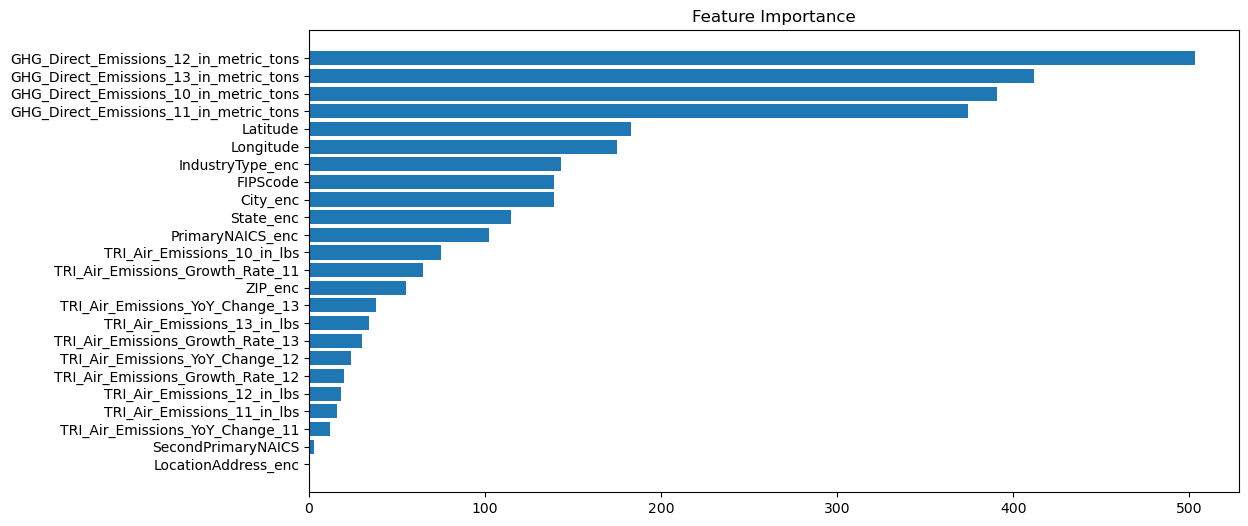

In [128]:

# show the feature importance
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, columns):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()

plot_feature_importance(model, numerical_columns)

In [129]:
submit  =  pd.read_csv ( 'sample_submission.csv' ,  header = None ) 
submit [ 1 ]  =  test_predictions 
submit.to_csv( 'submission_5.csv' ,  header = None ,  index = False )